In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import data_lib
import plot_lib
import transform_lib

In [3]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
-----------------------------------
Group: ../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
-----------------------------------
Group: ../Data/6P-positive-dilution-series-labelled/droplet-level-data/RawData
po-di

## Demistifying whitening (PCA)

See https://arxiv.org/pdf/1512.00809.pdf for details.

### PCA

PCA in general and in particular in this project can be seen as as basis transformation with scaling.
This can be seen by the very definition:
$$X^TX = U^T \Lambda U.$$
Note that we have the correspondence to SVD via $ X = V^T \Sigma U$ with the same $U$ as above and $\Sigma^2 = \Lambda$.
So applying a PCA transformation does nothing else than output
$$ \tilde{X} = X U \Lambda^{-1/2},$$
where we can understand $U^T$ as a projection into the Eigenvalue basis and $\Lambda^{-1/2}$ as the scaling.

Applied on this project, this means we loose the information encoded qualitatively in the axis, meaning the "color".

### General Whitening

A more general approch than PCA is whitening, here, we only want to transform $X$ linearly, such that the covariance of the transformed $X'$
is then equal to the identity. Note first that this will be the case in a PCA transformation.
$$ X'^TX' = I.$$
This is the only requirement we have for whitening. More explicitly we can express whitening of $X$ as a matrix $W$ such that
$$X' = X W^T.$$
For PCA this is given with $W = \Lambda^{-1/2} U^T$.

In theory $W$ can always be written as
$$W = Q \Lambda^{-1/2},$$
where $Q$ is some rotation matrix, and $\Lambda^{-1/2}$ makes sure that $X'^T X' = I$.
In PCA we have $Q = U$ and hence a change of Basis. The Idea is to just not do this basis transformation and choose
$$W = \Lambda^{-1/2}$$

### ZCA

This whitening method doesn nothing else than choose $W = \Lambda^{-1/2}$.

### ZCA-COR

This is one more extension, but looking closer, it does exactly the same thing as ZCA, with the small change that
we do first scale $X$ such that the variance of the columns of $X$ is one. So we have $Z = X V^{-1/2 }$ where
$V^{-1/2}$ is diagonal and just scales the variances to $0$. Then we apply ZCA on $Z$ and thats all.

On our data, the last method generates the most beatiful separation of positive and negative labelled data.


## Introduce Transform Lib

In [5]:
# compute transformation on all the data
df_all = data_lib.load_dataset([], None) # all data no labels
np_all = df_all.to_numpy()
PCA_whitener = transform_lib.WhitenTransformer(transform_lib.Whitenings.PCA)
ZCA_whitener = transform_lib.WhitenTransformer(transform_lib.Whitenings.ZCA_COR)
_ = PCA_whitener.fit(np_all)
_ = ZCA_whitener.fit(np_all)

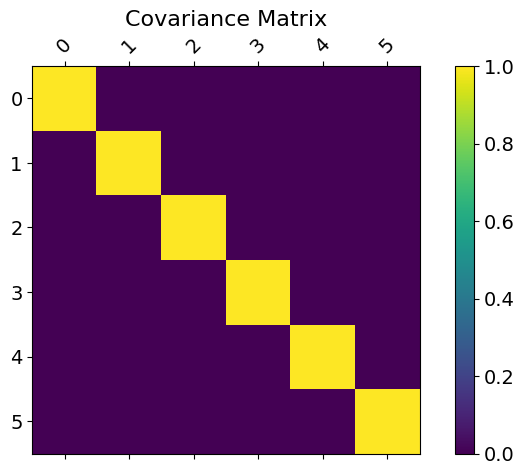

In [6]:
# check covariance PCA
X_PCA_all = PCA_whitener.transform(np_all)
plot_lib.plot_cov(pd.DataFrame(X_PCA_all))

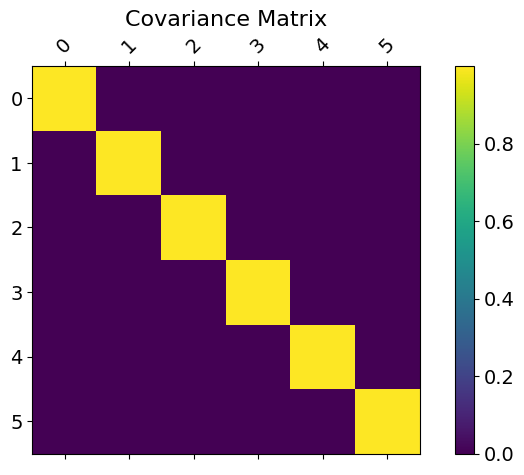

In [7]:
# check covariance ZCA
X_ZCA_all = ZCA_whitener.transform(np_all)
plot_lib.plot_cov(pd.DataFrame(X_ZCA_all))

In [8]:
# get plotting dataset
# None as labels corresponds to the ["IAV-M_POS", "IBV-M_POS", "MHV_POS", "RSV-N_POS", "SARS-N1_POS", "SARS-N2_POS"]
df_wa = data_lib.load_dataset(None, ["wa-sa-A1", "wa-sa-B1",
                                                 "wa-sa-A2", "wa-sa-B2", "wa-sa-C2", "wa-sa-D2",
                                                 "wa-sa-A3", "wa-sa-B3", "wa-sa-C3", "wa-sa-D3",
                                                 "wa-sa-A4", "wa-sa-B4", "wa-sa-C4", "wa-sa-D4",
                                                 "wa-sa-A5", "wa-sa-B5",
                                                ]) # waste water samples without controls
X_wa = df_wa.to_numpy(copy=True)[:,:6]
y_wa_IAV_M = df_wa.to_numpy(copy=True)[:,6]
y_wa_IBV_M = df_wa.to_numpy(copy=True)[:,7]
y_wa_MHV = df_wa.to_numpy(copy=True)[:,8]
y_wa_RSV = df_wa.to_numpy(copy=True)[:,9]
y_wa_SARS_N1 = df_wa.to_numpy(copy=True)[:,10]
y_wa_SARS_N2 = df_wa.to_numpy(copy=True)[:,11]
X_PCA_wa = PCA_whitener.transform(X_wa)
df_X_PCA_wa = pd.DataFrame(data=X_PCA_wa)
X_ZCA_wa = ZCA_whitener.transform(X_wa)
df_X_ZCA_wa = pd.DataFrame(data=X_ZCA_wa, columns=df_all.columns)

print(f'Waste water dataset shape: {df_wa.shape}')
print(f'PCA wast water shape: {X_PCA_wa.shape}')
print(f'X_ZCA wast water shape: {X_ZCA_wa.shape}')

Waste water dataset shape: (338881, 12)
PCA wast water shape: (338881, 6)
X_ZCA wast water shape: (338881, 6)


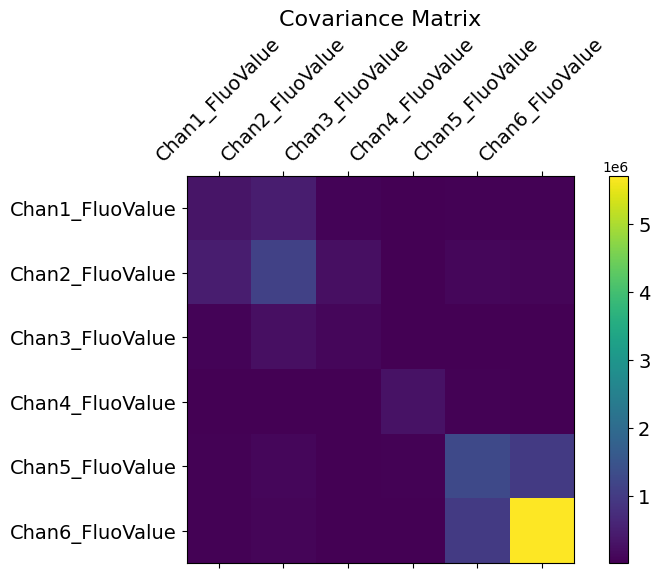

In [9]:
# plot covariance before transformation
plot_lib.plot_cov(df_wa.iloc[:, :6])

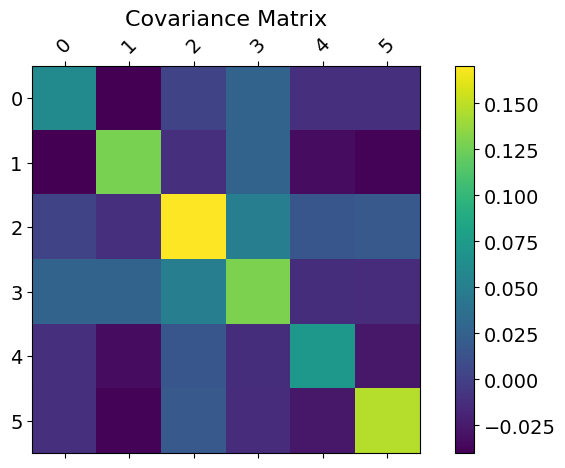

In [10]:
# plot covariance after transformation
df_X_PCA = pd.DataFrame(X_PCA_wa)
plot_lib.plot_cov(df_X_PCA)

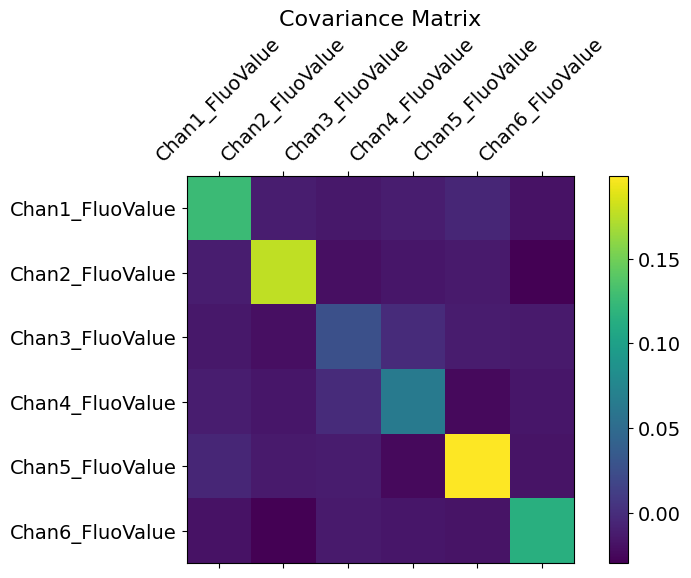

In [11]:
# plot covariance after transformation
df_X_ZCA = pd.DataFrame(data=X_ZCA_wa, columns=df_all.columns)
plot_lib.plot_cov(df_X_ZCA)

### PCA and ZCA for IAV-M on wastewater

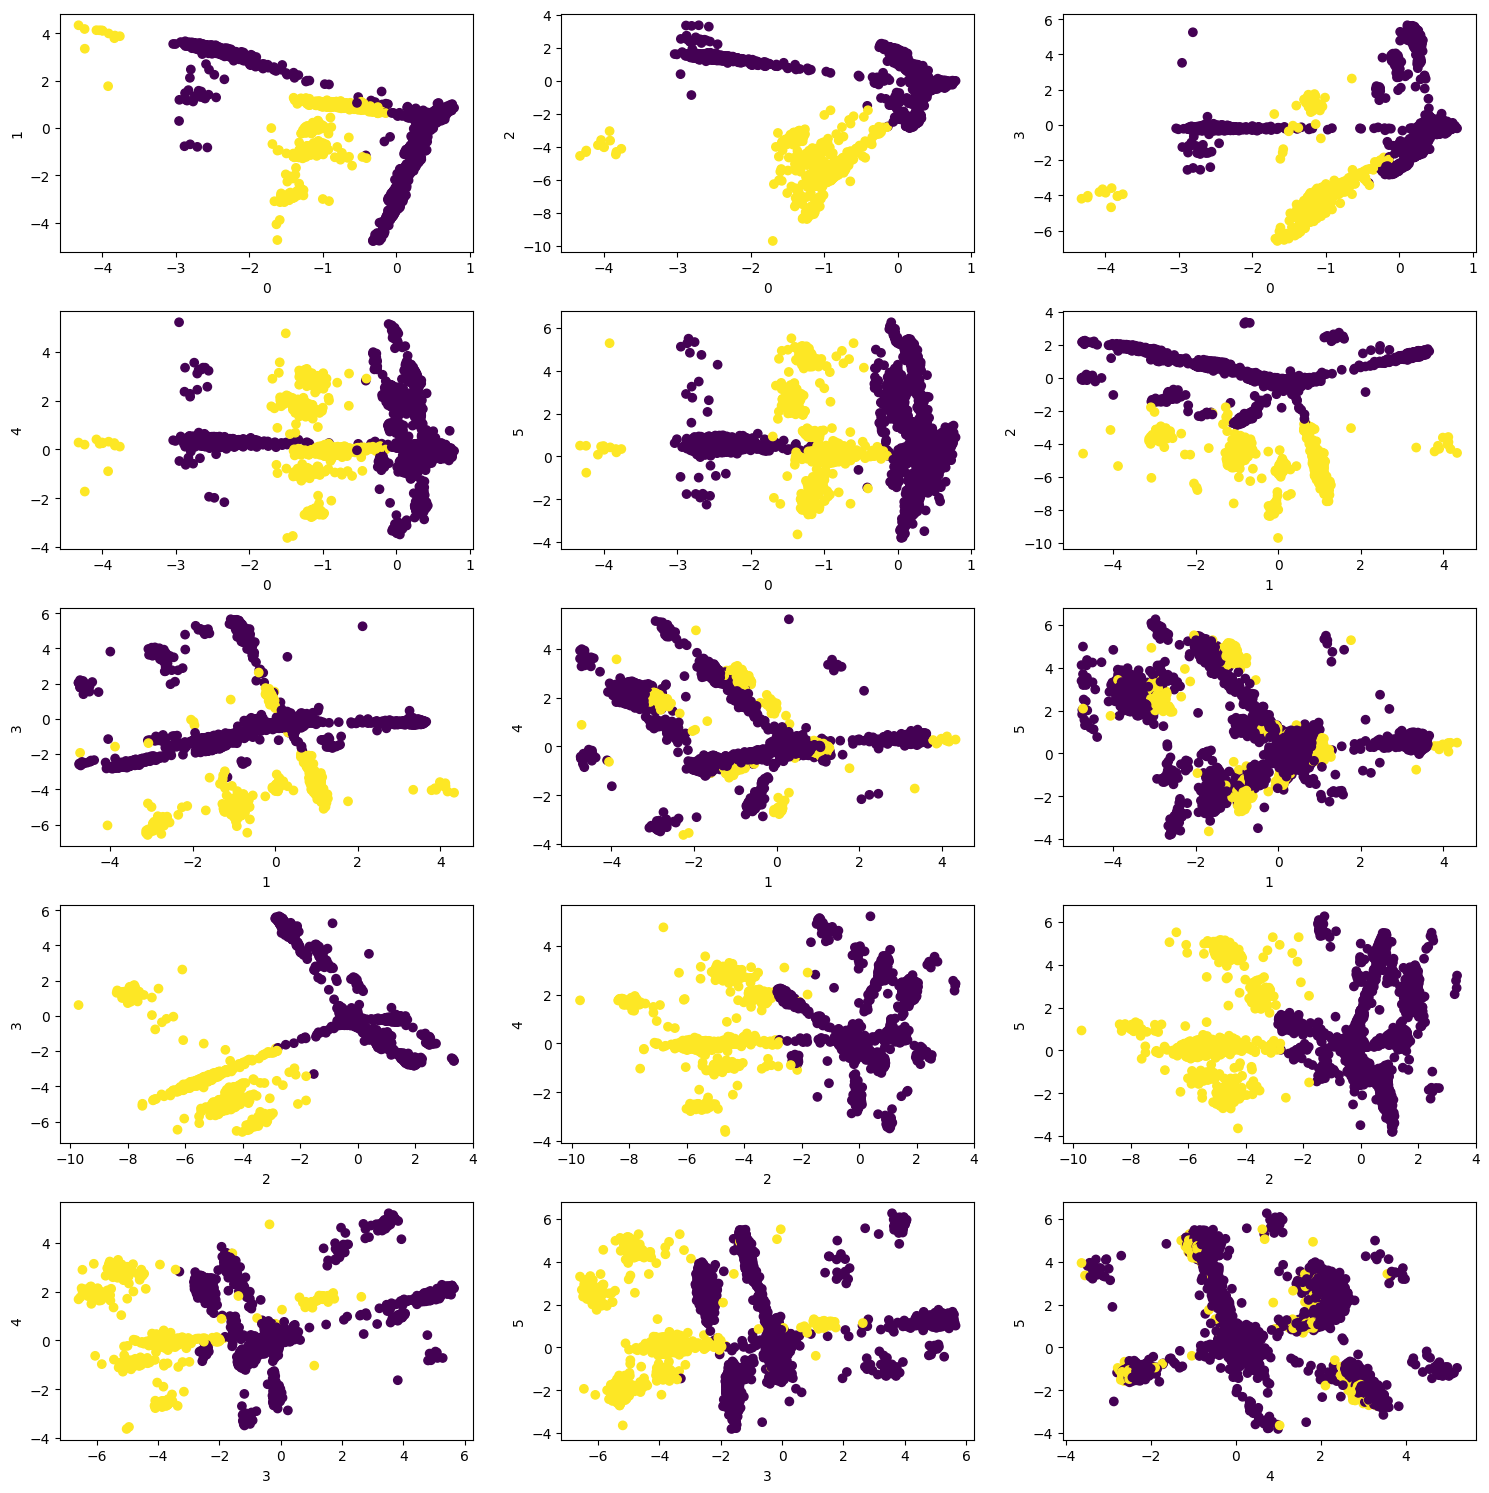

In [37]:
plot_lib.pairwise_plots(df_X_PCA_wa, y_wa_IAV_M)

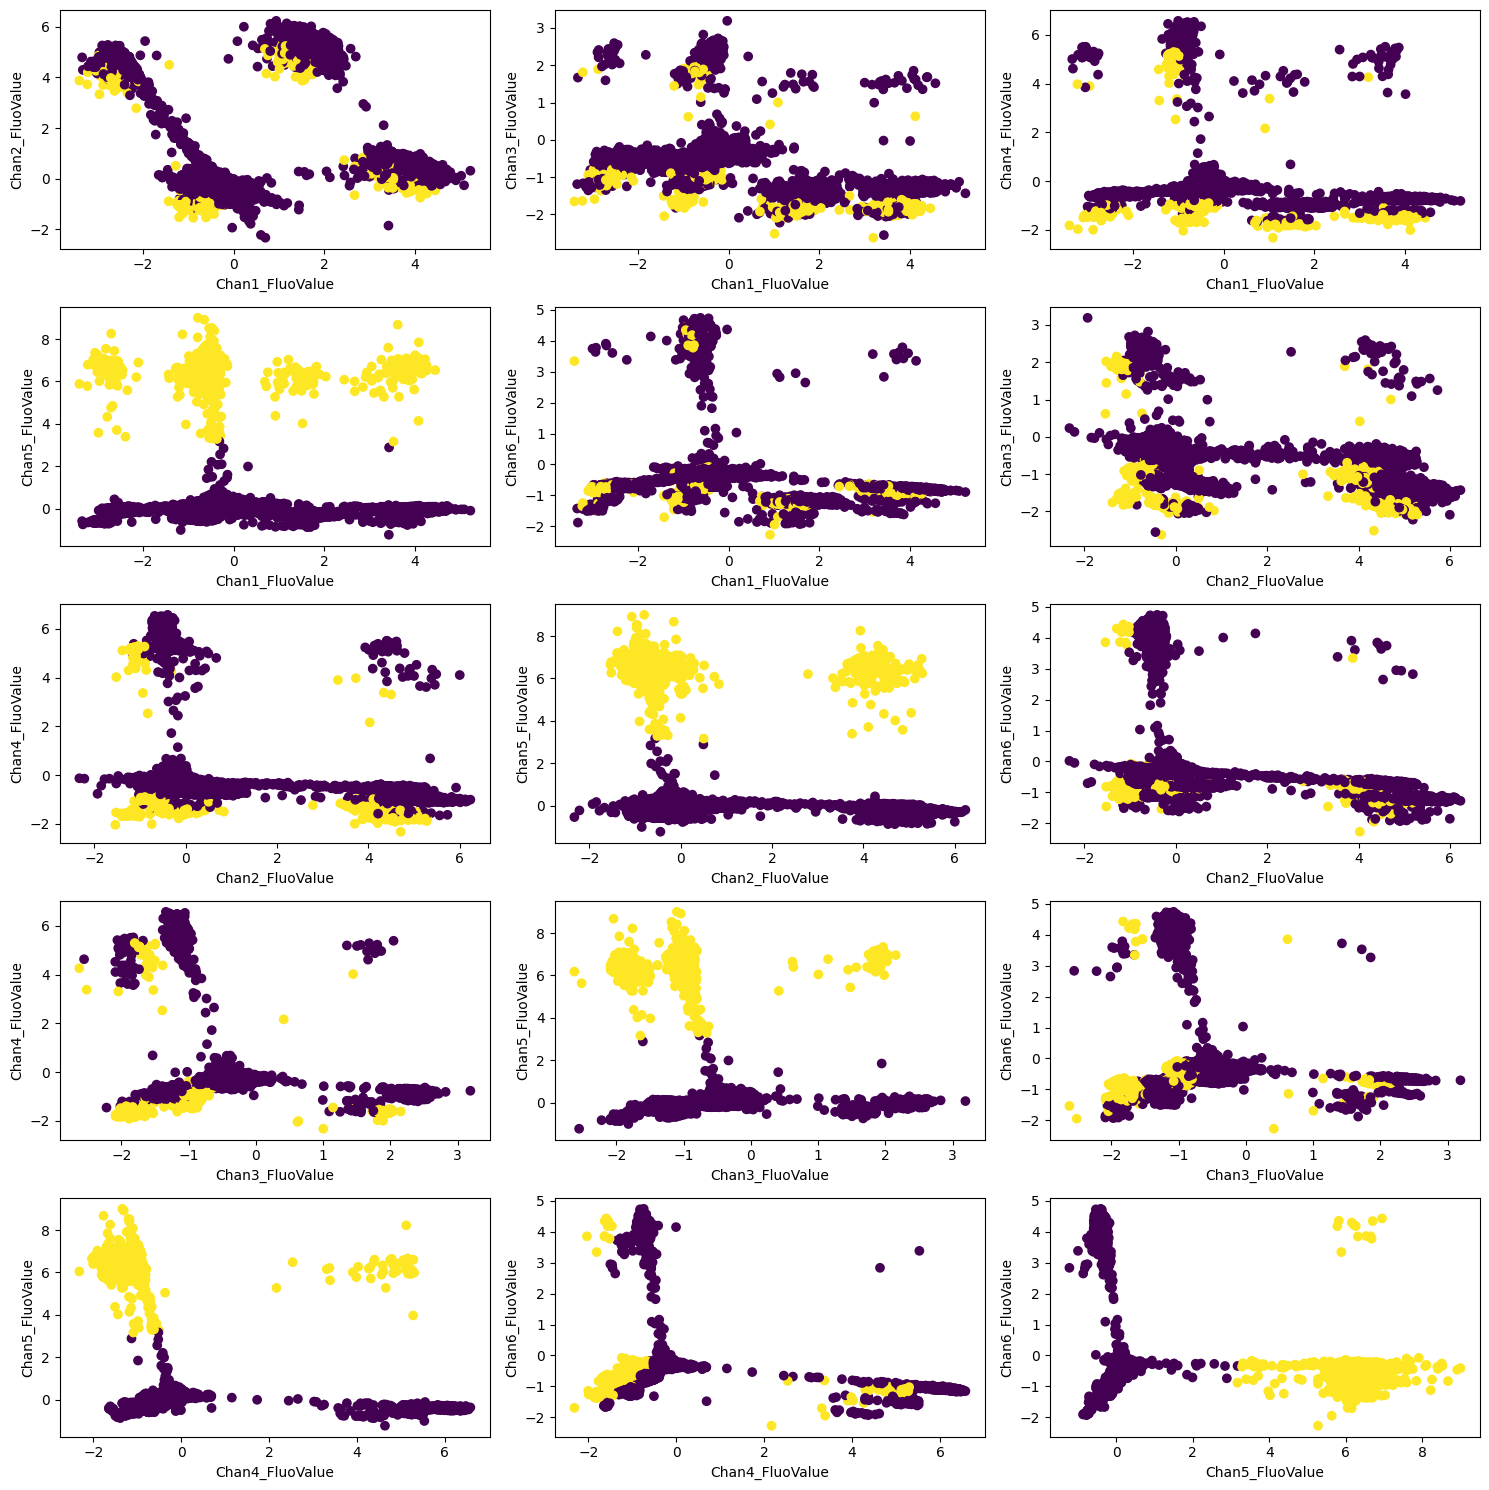

In [38]:
plot_lib.pairwise_plots(df_X_ZCA_wa, y_wa_IAV_M)

### PCA and ZCA for IBV-M on wastewater

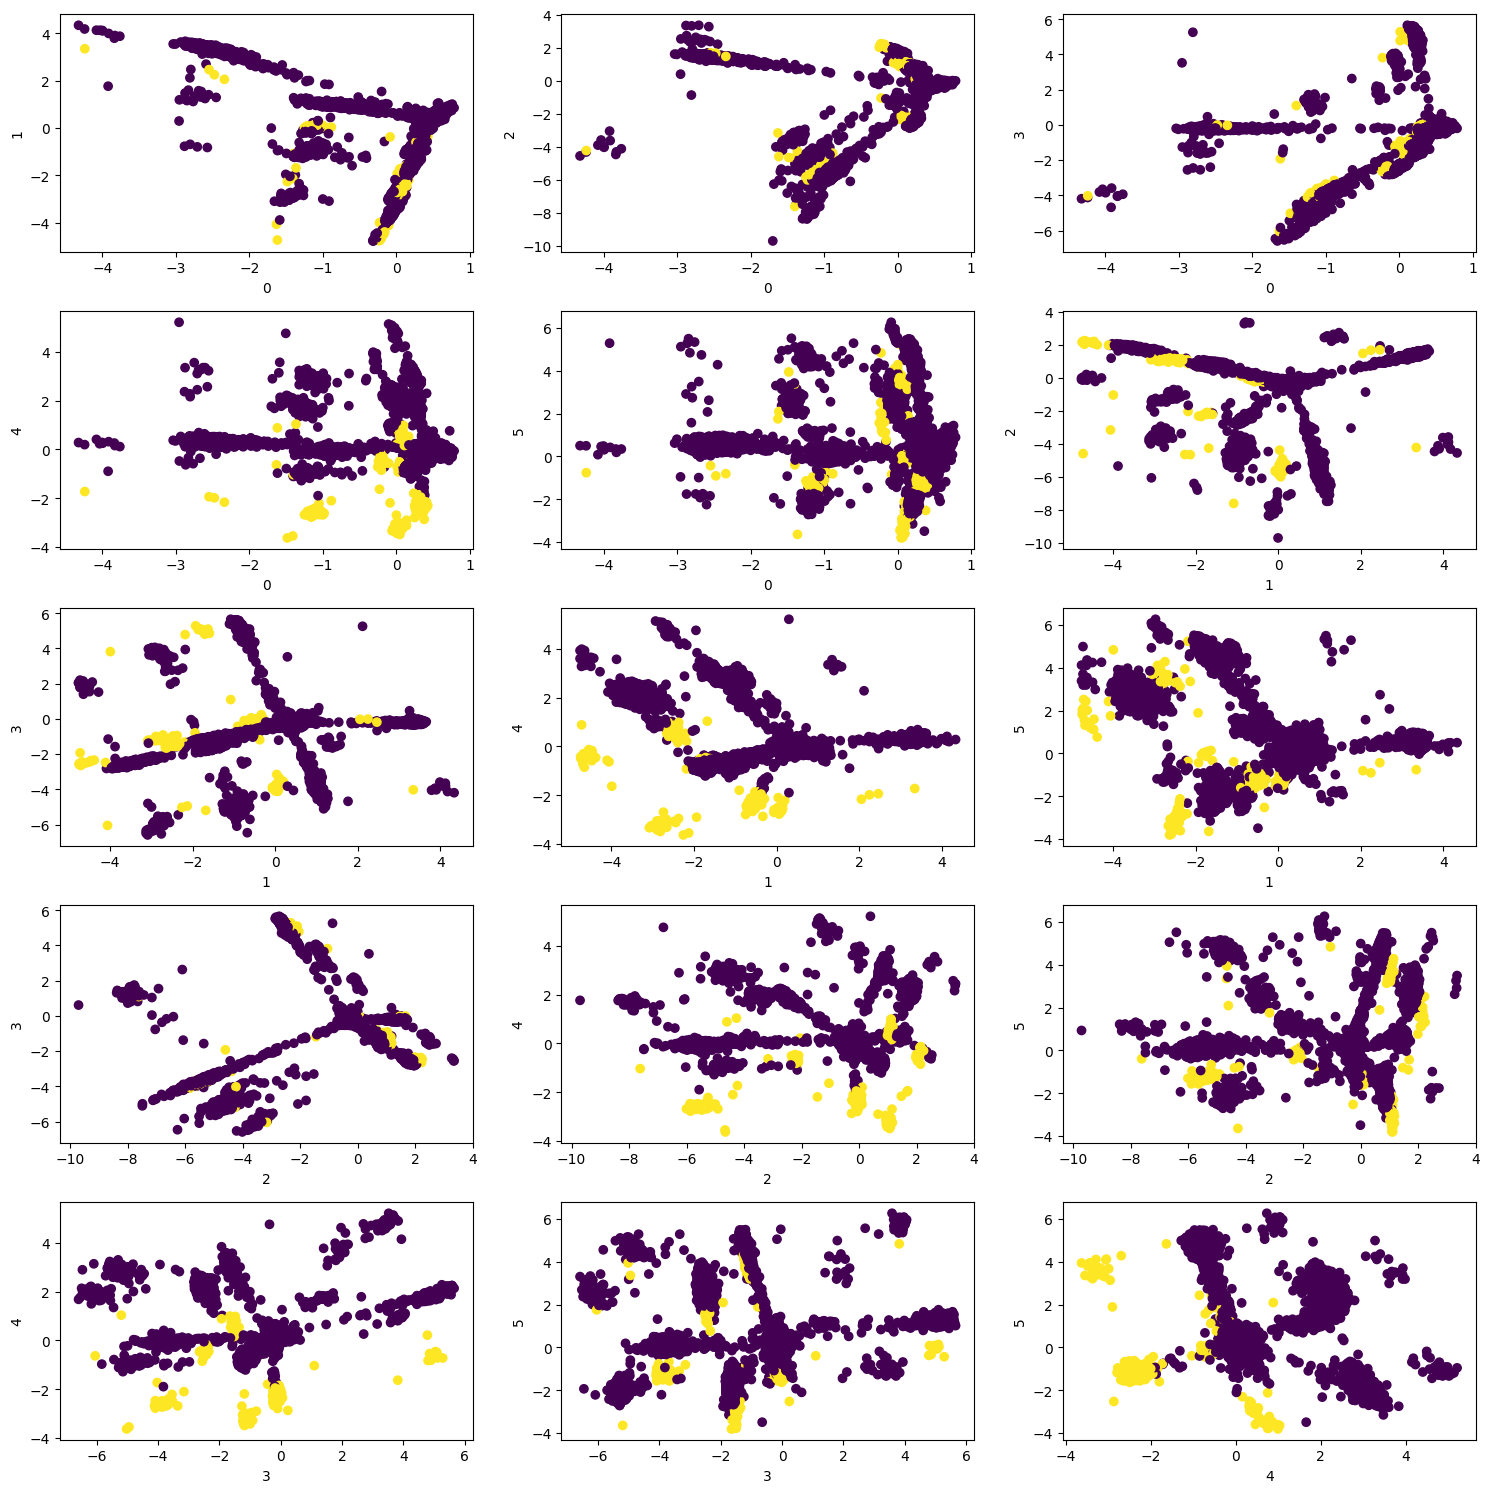

In [39]:
plot_lib.pairwise_plots(df_X_PCA_wa, y_wa_IBV_M)

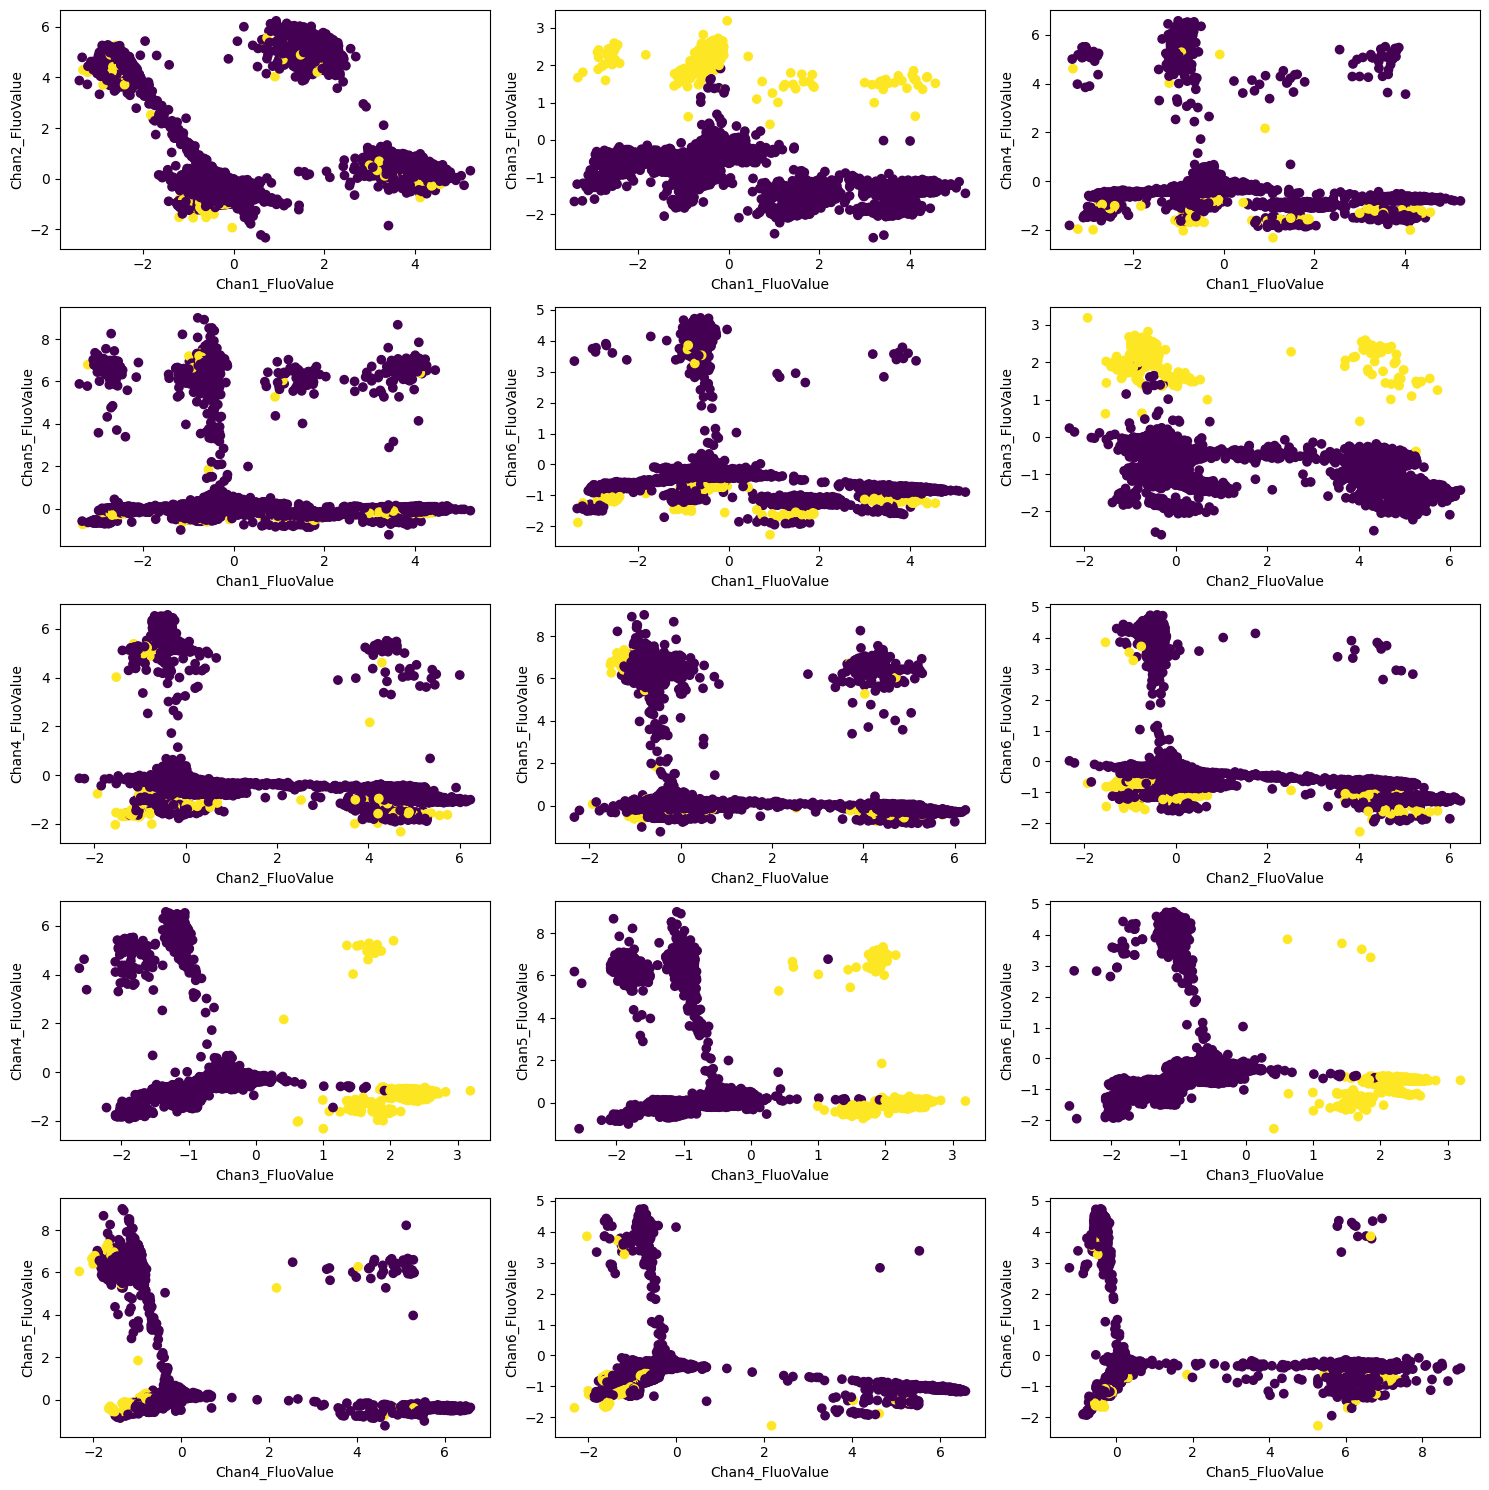

In [40]:
plot_lib.pairwise_plots(df_X_ZCA_wa, y_wa_IBV_M)

### PCA and ZCA for MHV on wastewater

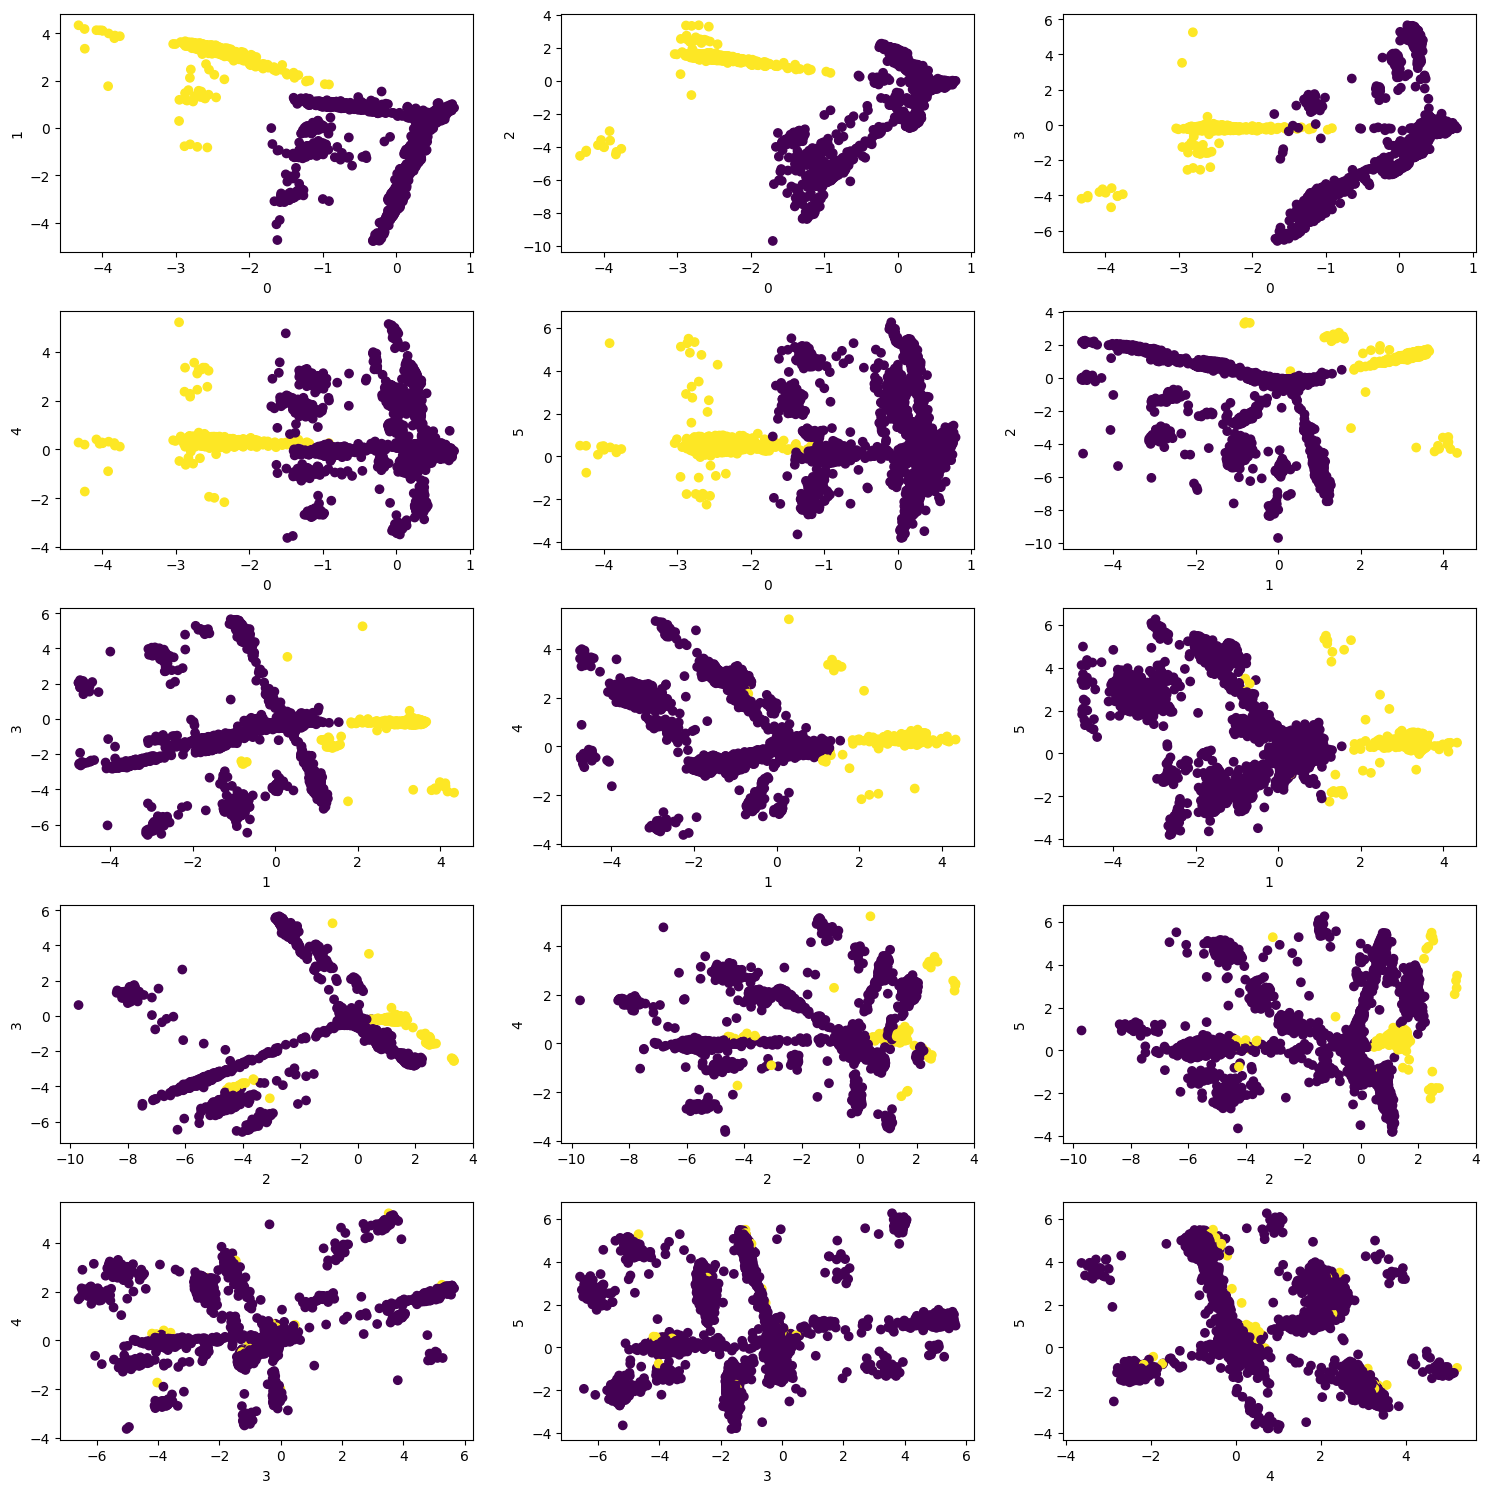

In [41]:
plot_lib.pairwise_plots(df_X_PCA_wa, y_wa_MHV)

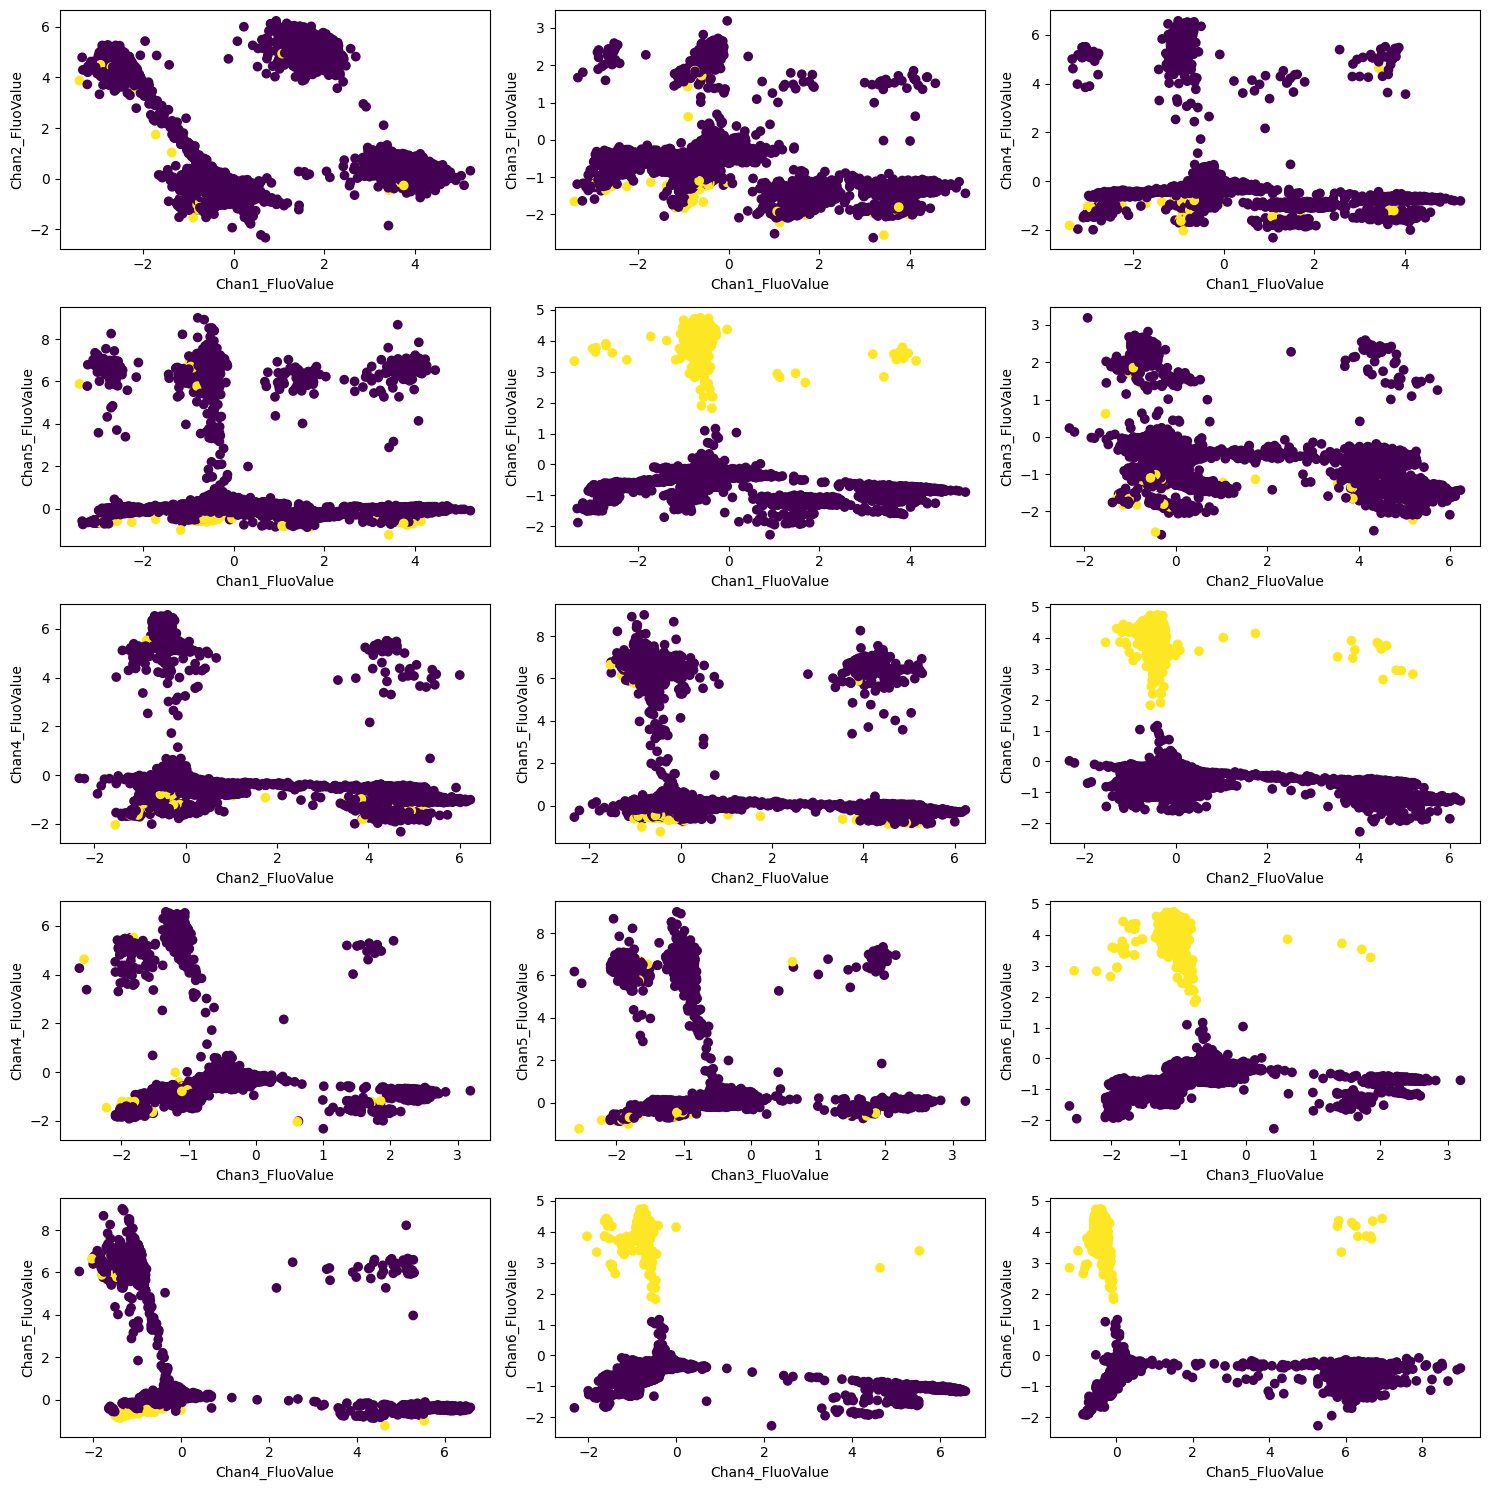

In [42]:
plot_lib.pairwise_plots(df_X_ZCA_wa, y_wa_MHV)

### PCA and ZCA for RSV-N on wastewater

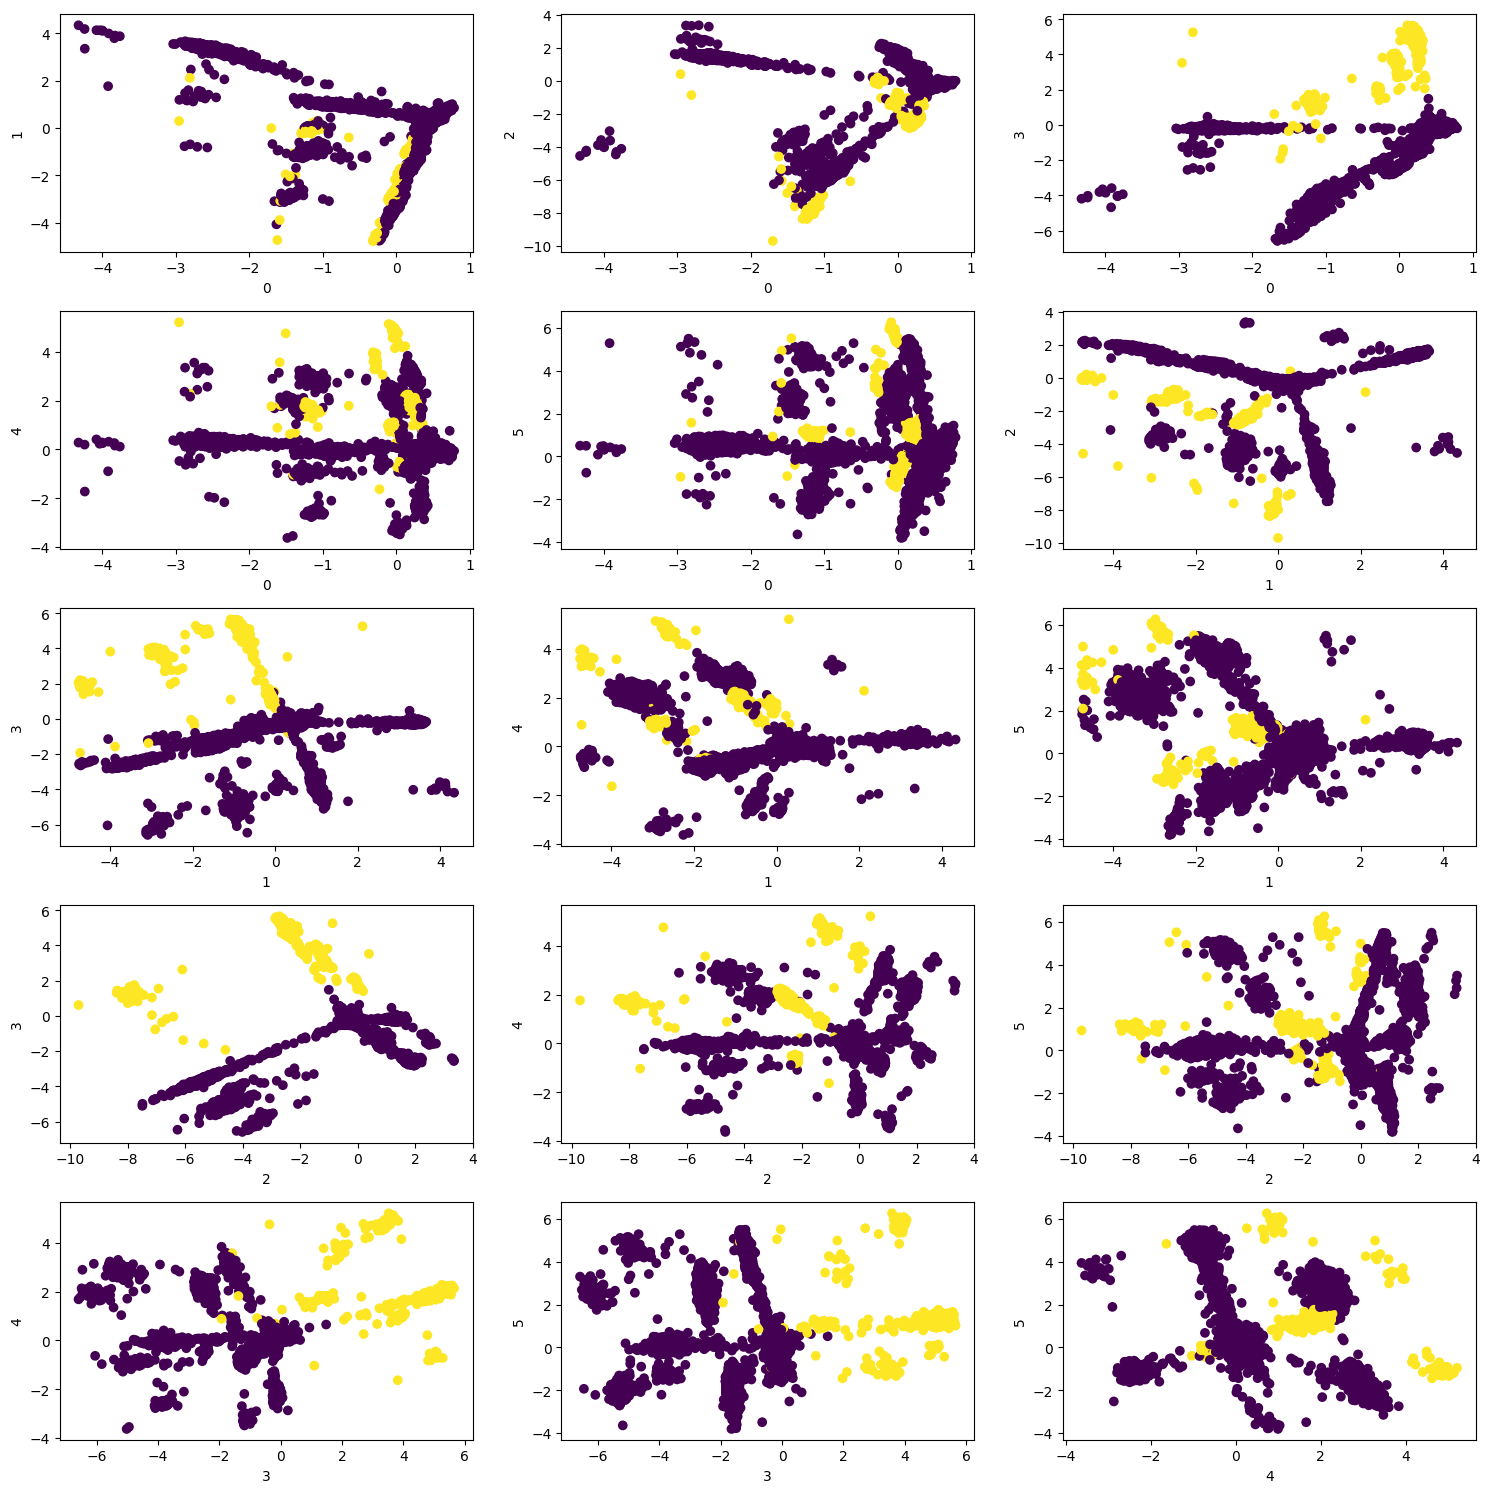

In [43]:
plot_lib.pairwise_plots(df_X_PCA_wa, y_wa_RSV)

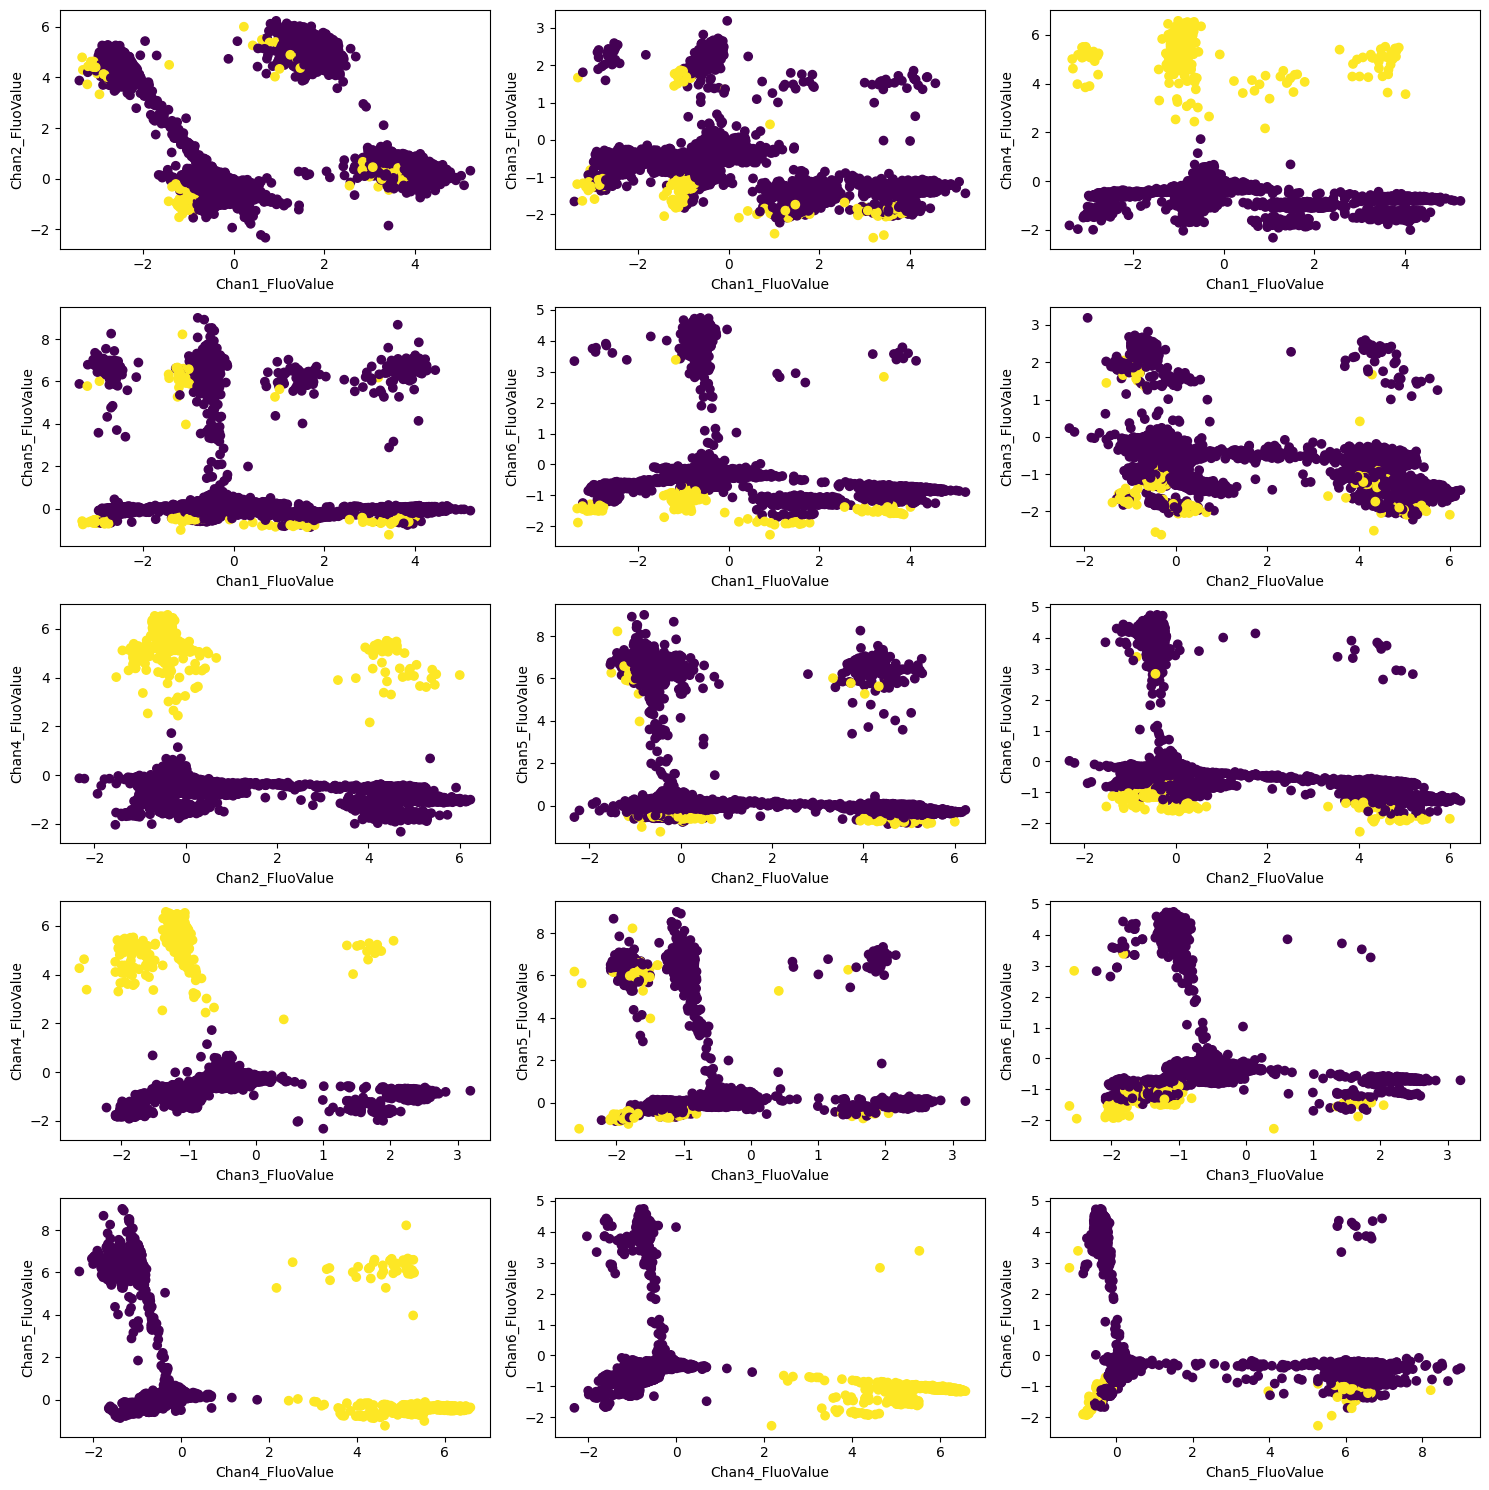

In [44]:
plot_lib.pairwise_plots(df_X_ZCA_wa, y_wa_RSV)

### PCA and ZCA for SARS-N1 on wastewater

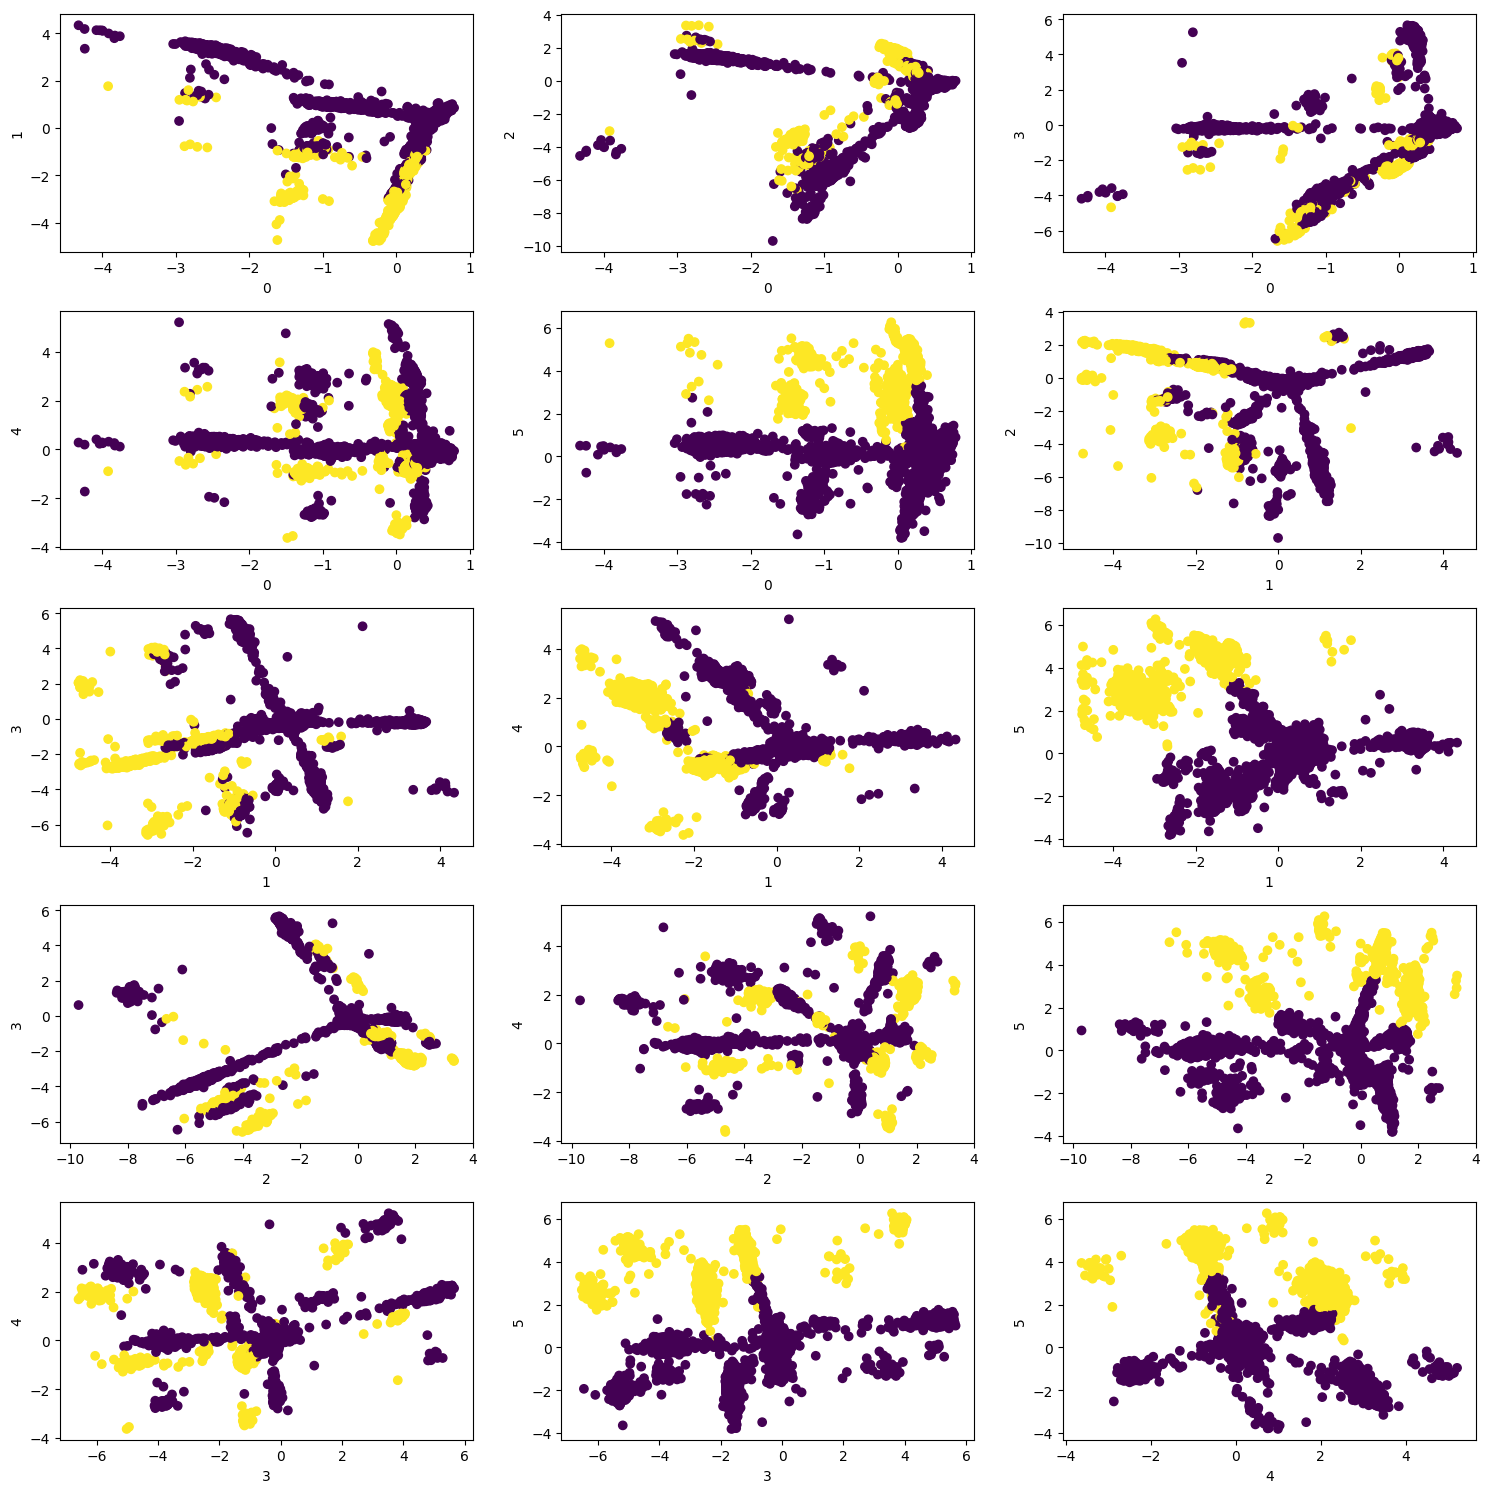

In [45]:
plot_lib.pairwise_plots(df_X_PCA_wa, y_wa_SARS_N1)

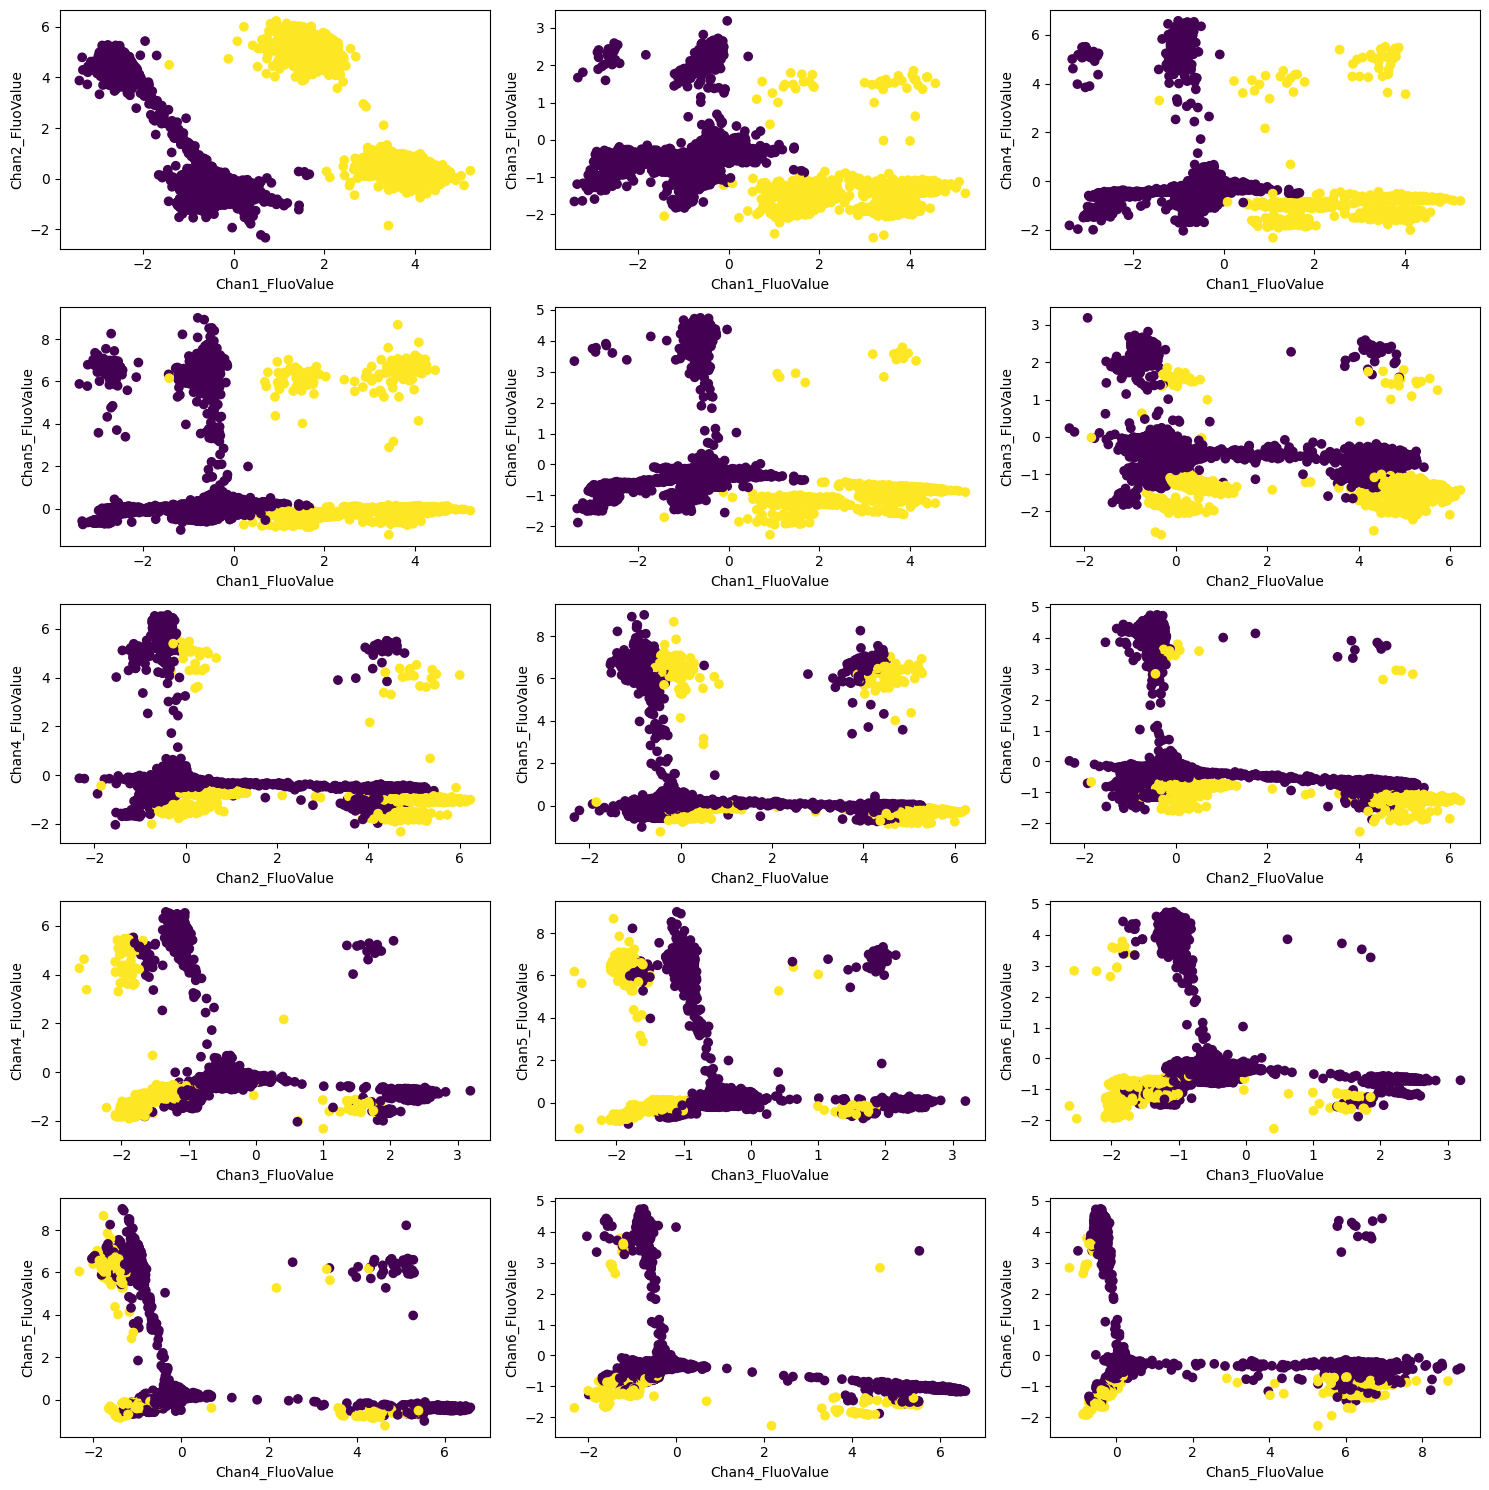

In [46]:
plot_lib.pairwise_plots(df_X_ZCA_wa, y_wa_SARS_N2)

### PCA and ZCA for SARS-N2 on wastewater

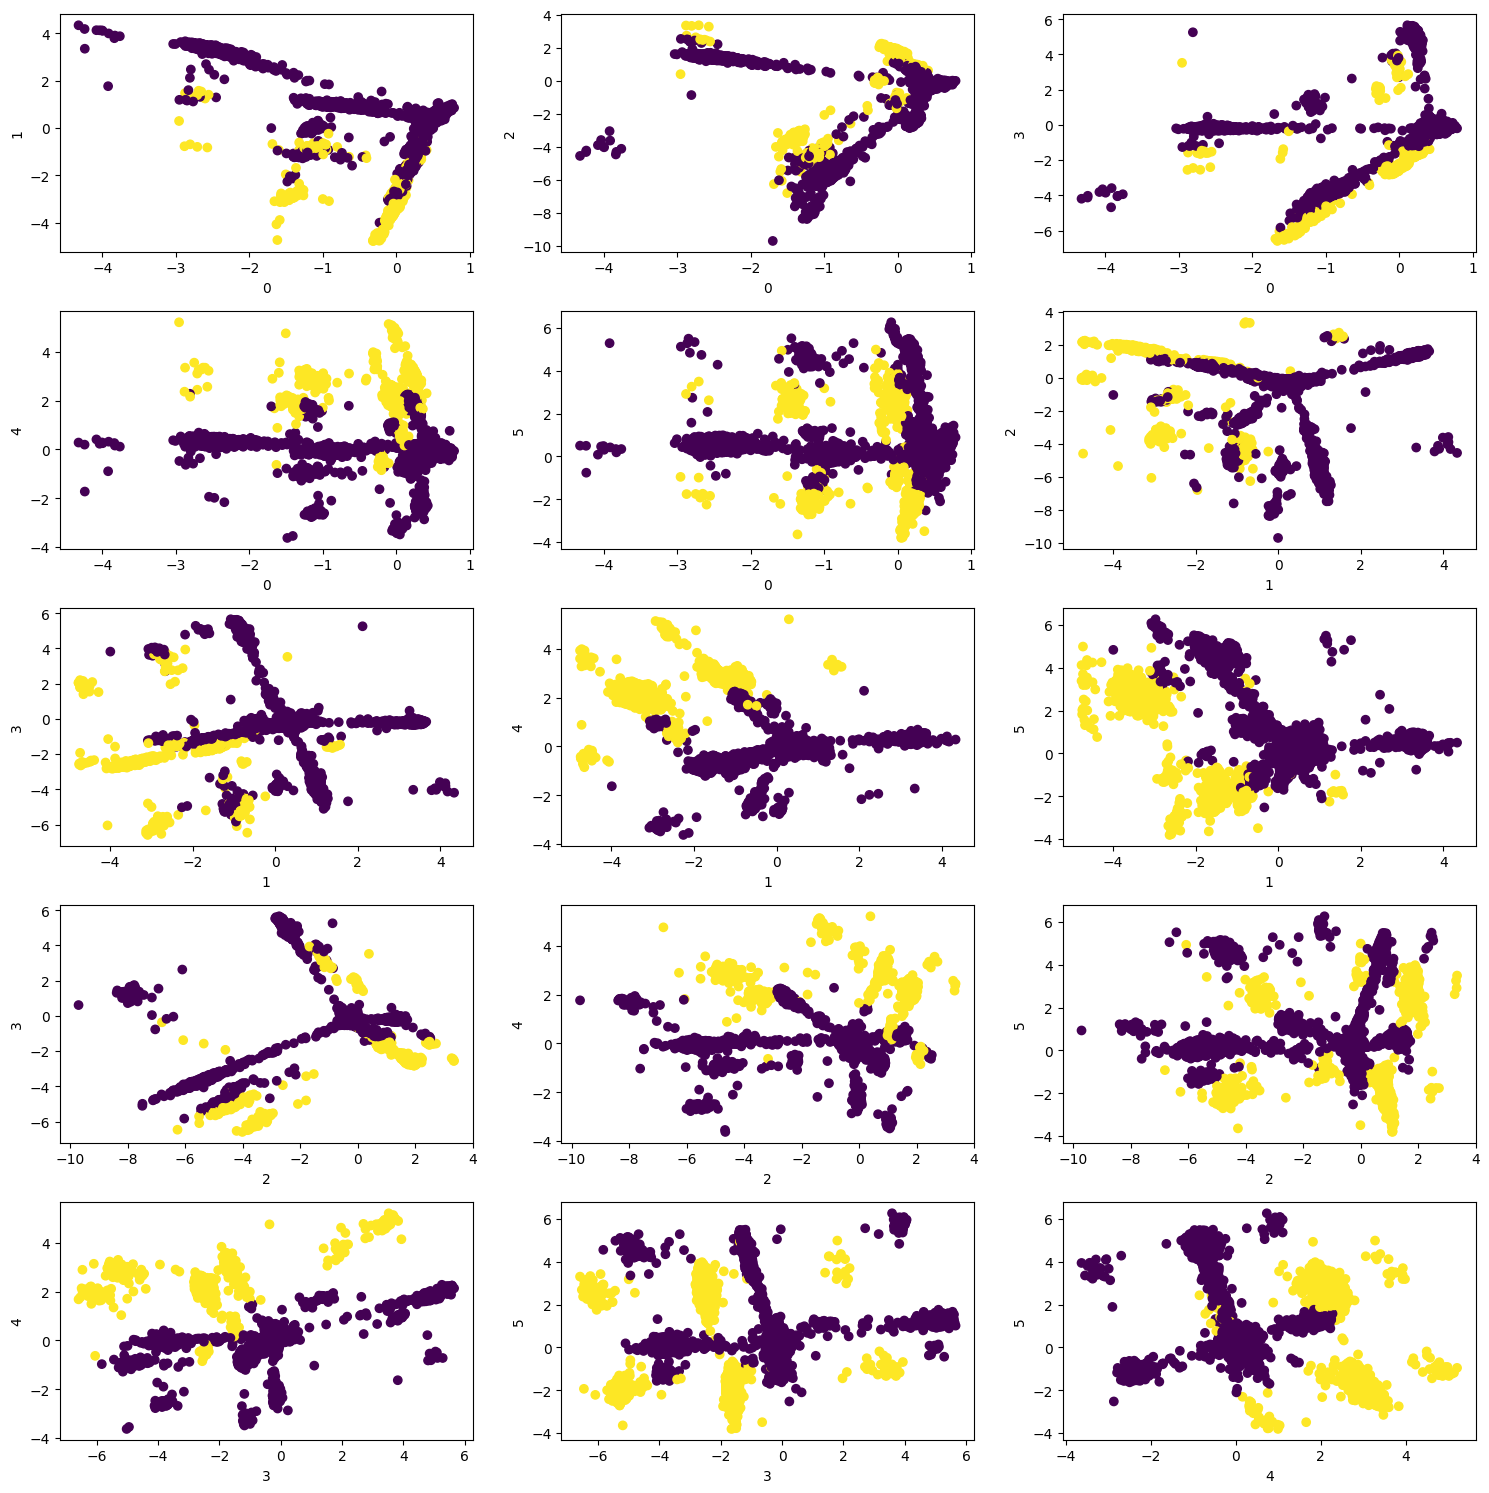

In [47]:
plot_lib.pairwise_plots(df_X_PCA_wa, y_wa_SARS_N2)

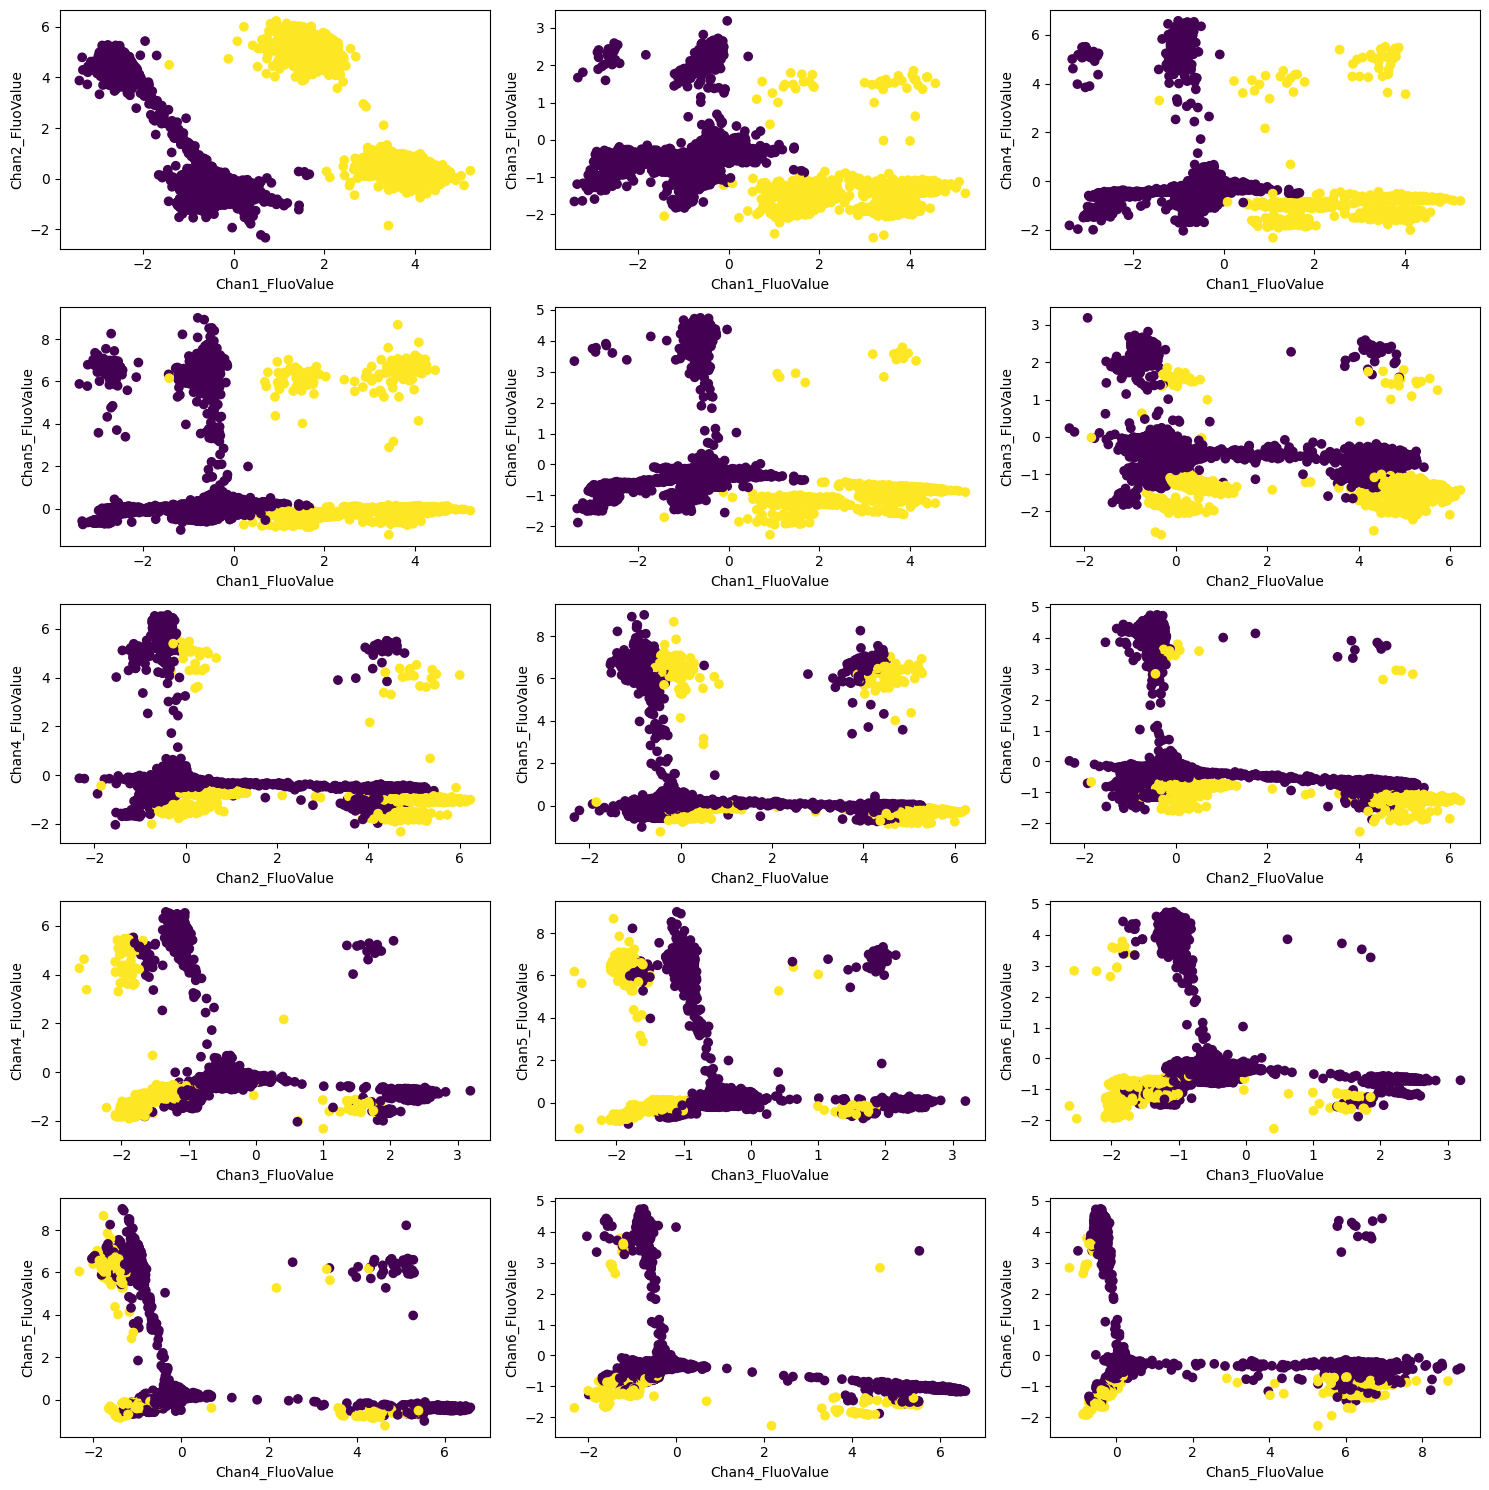

In [48]:
plot_lib.pairwise_plots(df_X_ZCA_wa, y_wa_SARS_N2)